<a href="https://colab.research.google.com/github/engabduallah/teknofest-green-matter/blob/main/Stroke_Classifier_Using_MedViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#capture
!pip install pydicom
!pip install gdcm
!pip install pylibjpeg pylibjpeg-libjpeg

In [2]:
!git clone https://github.com/Omid-Nejati/MedViT.git
%cd /content/MedViT

fatal: destination path 'MedViT' already exists and is not an empty directory.
/content/MedViT


In [3]:
!pip install -r requirements.txt

In [4]:
!pip install timm
!pip install einops

In [5]:
import os
import nibabel as nib  # Library for handling NIfTI files
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from torch.utils.data import random_split
from torch.utils.data import Dataset
from pydicom import dcmread
import pylibjpeg
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
!nvidia-smi

Fri Mar 21 19:17:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             48W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import medmnist
from medmnist import INFO, Evaluator
from torch.utils.data import Dataset

import torchattacks
from torchattacks import PGD, FGSM

In [8]:

print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)
print("Medmnist", medmnist.__version__)

PyTorch 2.6.0+cu124
Torchvision 0.21.0+cu124
Torchattacks 3.5.1
Numpy 2.0.2
Medmnist 3.0.1


In [9]:
class DICOMDataset(Dataset):
    def __init__(self, stroke_folder, no_stroke_folder, hemo_stroke_folder, transform=None):
        """
        Args:
            stroke_folder (string): Path to the folder containing stroke images.
            no_stroke_folder (string): Path to the folder containing non-stroke images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.stroke_folder = stroke_folder
        self.hemo_stroke_folder = hemo_stroke_folder
        self.no_stroke_folder = no_stroke_folder
        self.transform = transform

        self.image_paths = []
        self.labels = []


        for filename in os.listdir(self.stroke_folder):
            if filename.endswith(".dcm"):
                self.image_paths.append(os.path.join(self.stroke_folder, filename))
                self.labels.append(1)  # 1 for stroke

        for filename in os.listdir(self.hemo_stroke_folder):
            if filename.endswith(".dcm"):
                self.image_paths.append(os.path.join(self.hemo_stroke_folder, filename))
                self.labels.append(1)  # 1 for stroke

        for filename in os.listdir(self.no_stroke_folder):
            if filename.endswith(".dcm"):
                self.image_paths.append(os.path.join(self.no_stroke_folder, filename))
                self.labels.append(0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        dicom_path = self.image_paths[idx]
        dicom_data = dcmread(dicom_path)

        image = dicom_data.pixel_array

        image = image.astype(np.float32)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label


In [91]:
def create_dataloader(stroke_folder, no_stroke_folder, hemo_stroke_folder, batch_size=32, val_split=0.2, test_split=0.1, transform=None):
    # Initialize the dataset
    dataset = DICOMDataset(stroke_folder, no_stroke_folder,hemo_stroke_folder, transform=transform)

    # Calculate split sizes
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size - test_size

    # Split the dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Create DataLoaders for each dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    #transforms.Normalize(mean=[.5], std=[.5])
])

# Set paths to your DICOM folders
stroke_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/processed tkn /output_stroke'
no_stroke_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/processed tkn /output_no_stroke'
hemo_stroke_folder = '/content/drive/MyDrive/Colab Notebooks/datasets/processed tkn /output_hemo'

# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloader(stroke_folder, no_stroke_folder, hemo_stroke_folder, batch_size=32, val_split=0.2, test_split=0.1, transform=transform)



(224, 224, 1)


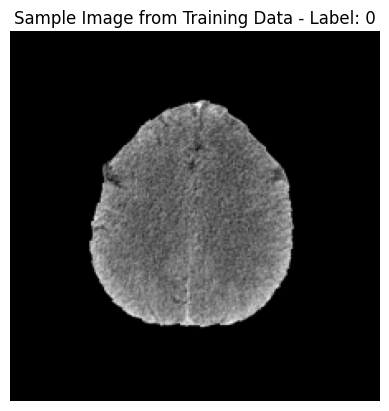

In [92]:
# Example: Fetch one sample from the training dataset and display it
for images, labels in train_loader:
    # Take the first image from the batch

    image = images[0].numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format for display
    print(image.shape)
    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f"Sample Image from Training Data - Label: {labels[0].item()}")
    plt.axis('off')  # Hide the axis
    plt.show()
    break  # Stop after plotting one image

In [93]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [94]:
cd /content/MedViT

/content/MedViT


In [95]:
from MedViT import MedViT_small, MedViT_base, MedViT_large, ConvBNReLU

#model = MedViT_small(num_classes = 1000).cuda()
#model = MedViT_base(num_classes = n_classes).cuda()
#model = MedViT_large(pretrained=False, attn_drop=0, drop=0, head_dim=32, mix_block_ratio=0.75, num_classes = 1000).cuda()
model = MedViT_large(num_classes = 1000).cuda()

initialize_weights...


In [96]:
# Load checkpoint (adjust path to your downloaded checkpoint)
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/models/MedViT_large_im1k.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Remove 'module.' prefix in case of DataParallel models
checkpoint = {k.replace('module.', ''): v for k, v in checkpoint['model'].items()}

model.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

In [97]:
if isinstance(model.stem[0], ConvBNReLU):
    old_conv = model.stem[0].conv  # Get the first convolutional layer

    # Create a new convolution layer with 1 input channel
    new_conv = nn.Conv2d(
        in_channels=1,  # Change from 3 to 1
        out_channels=old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        groups=old_conv.groups,
        bias=old_conv.bias is not None
    )

    # Initialize new weights by averaging the original 3-channel weights
    new_conv.weight = nn.Parameter(old_conv.weight.mean(dim=1, keepdim=True))

    # Replace the original convolutional layer
    model.stem[0].conv = new_conv

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [98]:
model.proj_head = nn.Sequential(
    nn.Linear(model.proj_head[0].in_features, 2)
)

In [99]:
model.proj_head[0]

Linear(in_features=1024, out_features=2, bias=True)

In [100]:
# Initialize the classification layer
nn.init.xavier_uniform_(model.proj_head[0].weight)
nn.init.zeros_(model.proj_head[0].bias)

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [101]:
for name, param in model.named_parameters():
    if param.device != device:
        param.data = param.data.to(device)
        if param.grad is not None:
            param.grad = param.grad.to(device)

In [102]:
def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                epochs: int = 10, learning_rate: float = 0.005, save_path: str = 'vit_mnist.pth') -> (list, list):
    """
    Trains the model and evaluates it on the validation set after each epoch.

    Parameters:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        epochs (int): The number of epochs to train the model.
        learning_rate (float): The learning rate for the optimizer.
        save_path (str): Path to save the trained model state.

    Returns:
        train_losses (tuple): A tuple containing lists of training losses per epoch.
        val_losses (tuple): A tuple containing lists of validation losses per epoch.
    """
    #optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=[0.9, 0.999], weight_decay=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=5e-6)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            output = model(data)  # Forward pass
            loss = criterion(output, target)  # Loss calculation
            loss.backward()  # Backward pass (backpropagation)
            optimizer.step()  # Optimize model parameters
            train_loss += loss.item()

        # Store average training loss
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        val_loss = 0.0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item()

        # Store average validation loss
        val_losses.append(val_loss / len(val_loader))

        # Print epoch summary
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

        scheduler.step()  # Adjust learning rate

    # Save the trained model state
    torch.save(model.state_dict(), save_path)

    # Plot training and validation losses
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses


Epoch 1/50, Train Loss: 0.5993, Val Loss: 0.7107
Epoch 2/50, Train Loss: 0.3611, Val Loss: 0.4184
Epoch 3/50, Train Loss: 0.3497, Val Loss: 0.7935
Epoch 4/50, Train Loss: 0.3324, Val Loss: 0.7457
Epoch 5/50, Train Loss: 0.3073, Val Loss: 0.3339
Epoch 6/50, Train Loss: 0.2290, Val Loss: 0.2234
Epoch 7/50, Train Loss: 0.2178, Val Loss: 0.2003
Epoch 8/50, Train Loss: 0.1805, Val Loss: 0.2346
Epoch 9/50, Train Loss: 0.1685, Val Loss: 0.1982
Epoch 10/50, Train Loss: 0.1802, Val Loss: 0.2032
Epoch 11/50, Train Loss: 0.1557, Val Loss: 0.1855
Epoch 12/50, Train Loss: 0.1483, Val Loss: 0.1846
Epoch 13/50, Train Loss: 0.1467, Val Loss: 0.1808
Epoch 14/50, Train Loss: 0.1436, Val Loss: 0.1872
Epoch 15/50, Train Loss: 0.1319, Val Loss: 0.1969
Epoch 16/50, Train Loss: 0.1304, Val Loss: 0.1884
Epoch 17/50, Train Loss: 0.1264, Val Loss: 0.1916
Epoch 18/50, Train Loss: 0.1296, Val Loss: 0.1958
Epoch 19/50, Train Loss: 0.1292, Val Loss: 0.1910
Epoch 20/50, Train Loss: 0.1265, Val Loss: 0.1918
Epoch 21/

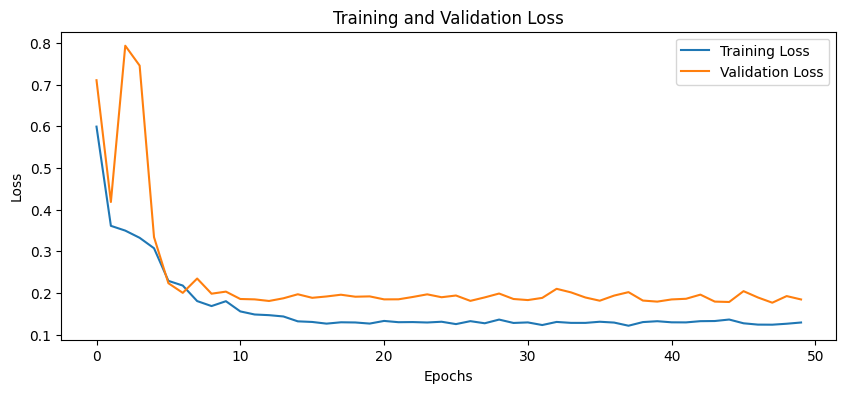

([0.5992694786966664,
  0.3611256151574932,
  0.3496600306809765,
  0.33237677062415094,
  0.3073191196747022,
  0.22904446251588326,
  0.21775319230781026,
  0.18051715141596042,
  0.16853474453091621,
  0.1802046960219741,
  0.15570872611276906,
  0.14829613880751885,
  0.14669980481904868,
  0.14356574546290587,
  0.13187492733234413,
  0.13038703169010274,
  0.12636259648540657,
  0.1296007463274753,
  0.12915146080394313,
  0.12650145383628264,
  0.13287199536108807,
  0.1298062750840024,
  0.13010348135937158,
  0.12909891555876765,
  0.13091198553981848,
  0.12524075001120977,
  0.13232109773495834,
  0.12723415342401967,
  0.13609505449868228,
  0.12799869035051703,
  0.1292904459118639,
  0.12300289399309518,
  0.13044695918486543,
  0.1281797410537527,
  0.12815136550479148,
  0.13089425980483424,
  0.1289114082193844,
  0.12135139703495454,
  0.1300968171850051,
  0.13217020393285442,
  0.12952512996398832,
  0.1293410699725253,
  0.1322741283563106,
  0.13263469442010742,
 

In [103]:
train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001)

In [ ]:
images, labels = next(iter(train_loader))
# Getting the size of the first image in the batch
get_image_size = images[0].size()
print(get_image_size)
# Getting the number of classes
unique_labels = set()
for _, labels in train_loader:
    unique_labels.update(labels.tolist())

get_num_classes = len(unique_labels)
print(get_num_classes)

In [ ]:
from torchsummary import summary
summary(model, input_size=(get_image_size[0], get_image_size[1], get_image_size[2]))

In [104]:
def test_model(model: nn.Module, test_loader: DataLoader, load_path: str = 'vit_mnist.pth') -> None:
    """
    Evaluates the model on the test dataset.

    Parameters:
        model (nn.Module): The neural network model to be evaluated.
        test_loader (DataLoader): DataLoader for the test dataset.
        load_path (str): Path to the file from which the model state is loaded.
    """
    # Load the saved model state
    model.load_state_dict(torch.load(load_path, map_location=device))  # Ensure model loads to the correct device
    model.eval()  # Set the model to evaluation mode

    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  # No gradient calculation for inference
        for data, target in test_loader:
            # Move data and target to the same device as the model
            data, target = data.to(device), target.to(device)

            # Forward pass and loss calculation
            output = model(data)
            test_loss += criterion(output, target).item()

            # Prediction and accuracy calculation
            pred = output.argmax(dim=1, keepdim=False)  # `pred` will have the same batch size as `target`
            correct += pred.eq(target).sum().item()

            # Storing all predictions and targets for F1 score calculation
            all_preds.extend(pred.cpu().tolist())  # Convert to list and extend
            all_targets.extend(target.cpu().tolist())  # Convert to list and extend

    # Calculate average test loss and accuracy
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)

    # Calculate F1 score
    f1 = f1_score(all_targets, all_preds, average='weighted')

    # Print results
    print(f'\n\n Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2%}), F1 Score: {f1:.4f}')


In [105]:
test_model(model, test_loader)



 Test set: Average loss: 0.2289, Accuracy: 618/665 (92.93%), F1 Score: 0.9283


# Finetuning